In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import utils as ut
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# CLEANING

# all gene data, includes dpi and gene expression, we only care about the pig indexes
gd = pd.read_csv('./allfile_counts.csv', delimiter= '\t', header=0, index_col=0)

# these are normalized values but dont include the pig indices and dpi
gdn = pd.read_csv('./normalized_counts2.txt', delimiter= '\t', header=0, index_col=0).transpose()

# give it their respective index, still doesnt have index
gdn.index = gd.index
gdn['dpi'] = gd['dpi']
gdn.head()

,ENSSSCG00000000001,ENSSSCG00000000002,ENSSSCG00000000003,ENSSSCG00000000004,ENSSSCG00000000005,ENSSSCG00000000006,ENSSSCG00000000007,ENSSSCG00000000010,ENSSSCG00000000011,ENSSSCG00000000013,...,ENSSSCG00000031062,ENSSSCG00000031063,ENSSSCG00000031064,ENSSSCG00000031065,ENSSSCG00000031066,ENSSSCG00000031067,ENSSSCG00000031068,ENSSSCG00000031069,ENSSSCG00000031070,dpi
-5001,2.394196,37.110038,790.084684,0.000000,292.091913,2.394196,302.865795,14.365176,0.0,0.000000,...,0.0,25.139058,29.927450,0.0,0.0,0.0,0.0,0.0,0.0,0
-5001,6.514008,73.825428,837.050071,0.000000,292.044707,1.085668,462.494592,20.627693,0.0,0.000000,...,0.0,51.026399,6.514008,0.0,0.0,0.0,0.0,0.0,0.0,14
-5001,3.260678,120.645091,698.600292,0.000000,181.782806,0.000000,298.352050,10.597204,0.0,0.000000,...,0.0,25.270256,10.597204,0.0,0.0,0.0,0.0,0.0,0.0,21
-5001,3.593402,72.586721,486.546632,1.437361,102.771297,4.312082,237.164533,7.905484,0.0,0.000000,...,0.0,13.654928,7.905484,0.0,0.0,0.0,0.0,0.0,0.0,28
-5002,5.311616,96.936986,820.644617,0.000000,221.317319,0.442635,249.203301,5.311616,0.0,1.327904,...,0.0,23.017001,5.754250,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# only keep columns where the logchange > 0.13, why? idk
de = pd.read_csv('./deGenes2.txt', delimiter= '\t', header=0, index_col=0)

# select the genes with logchange > 0.13, idk why
logchange=0.13
gdn_keep = gdn[de[de['log2FoldChange'].abs() > logchange].index.tolist()]
gdn_keep

,ENSSSCG00000000574,ENSSSCG00000000915,ENSSSCG00000002471,ENSSSCG00000002780,ENSSSCG00000003140,ENSSSCG00000003497,ENSSSCG00000006678,ENSSSCG00000007369,ENSSSCG00000009361,ENSSSCG00000010190,ENSSSCG00000010771,ENSSSCG00000011441,ENSSSCG00000013311,ENSSSCG00000015717,ENSSSCG00000016157,ENSSSCG00000022045,ENSSSCG00000024651,ENSSSCG00000025268,ENSSSCG00000025416,ENSSSCG00000026943
-5001,0.000000,47.883920,426.166890,208.295053,0.000000,0.000000,134.074977,0.000000,11.970980,45.489724,2.394196,1.197098,3.591294,0.000000,2.394196,0.000000,10.773882,23.941960,2.394196,0.000000
-5001,0.000000,2.171336,1802.208972,113.995146,2.171336,1.085668,542.834028,0.000000,2.171336,0.000000,1.085668,0.000000,3.257004,0.000000,1.085668,2.171336,19.542025,4.342672,0.000000,2.171336
-5001,0.815170,3.260678,315.470610,89.668649,3.260678,8.966865,236.399165,0.000000,1.630339,0.000000,0.815170,0.000000,2.445509,4.891017,0.000000,1.630339,95.374836,4.891017,0.000000,1.630339
-5001,0.000000,2.874722,67.555958,310.469934,0.000000,1.437361,138.705318,0.000000,1.437361,11.498886,0.718680,0.000000,0.000000,0.000000,0.718680,0.000000,41.683463,7.905484,7.905484,0.718680
-5002,3.983712,6.639520,2194.582532,20.803828,2.655808,0.885269,544.440604,0.000000,4.426346,0.000000,0.000000,0.000000,7.967423,0.000000,0.000000,0.442635,37.623944,0.885269,2.213173,0.442635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-5178,26.379492,0.000000,4286.667442,13.189746,1.465527,1.465527,2041.479572,0.000000,0.000000,0.000000,0.000000,0.000000,20.517383,0.000000,0.000000,0.000000,42.500293,17.586328,1.465527,85.000585
-5178,3.918425,5.877637,1180.425389,56.817156,1.959212,5.877637,518.211644,0.000000,4.898031,0.000000,0.979606,0.000000,8.816455,0.979606,0.000000,0.000000,32.327002,4.898031,5.877637,0.979606
-5186,5.118035,103.640211,594.971580,34.546737,2.559018,3.838526,586.015019,1.279509,69.093474,44.782807,0.000000,0.000000,7.677053,0.000000,5.118035,0.000000,20.472140,30.708211,3.838526,3.838526
-5186,5.124375,6.405469,1833.245153,24.340781,1.281094,1.281094,810.932342,0.000000,10.248750,0.000000,0.000000,0.000000,16.654219,0.000000,0.000000,1.281094,1.281094,1.281094,1.281094,2.562187


## Testing functions on 1 gene

In [4]:
# splits dataframe of those with and without na and formats them
w_na, wo_na = ut.na_split('ENSSSCG00000000574', gdn)

In [5]:
# performs imputation methods on the split data
poly_df, poly_func, interp_df, interp_func, knn_df, knn_func, knn_scores = ut.impute_methods(w_na, wo_na)

In [6]:
knn_scores

93.47172135402197

## Plotting the spline and polynomial and knn imputations

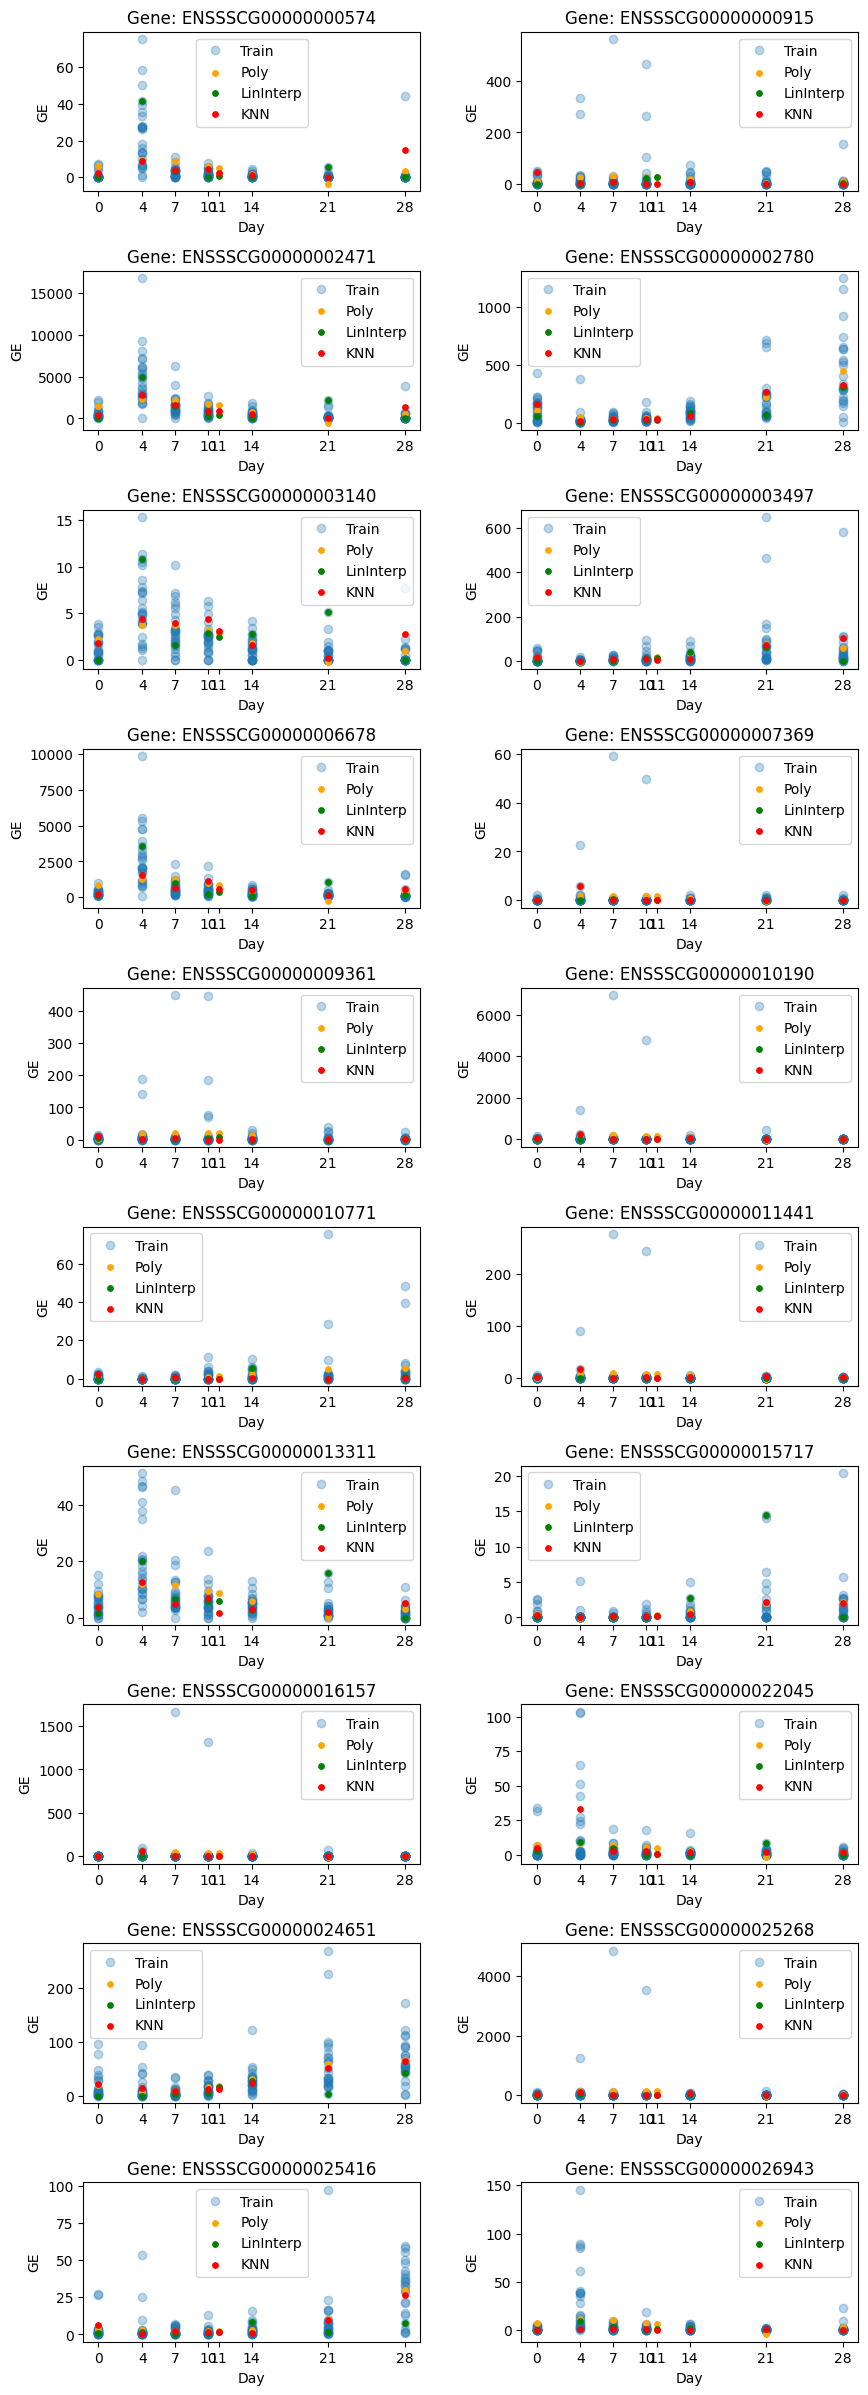

In [7]:
nrows = int(len(gdn_keep.columns)/2)  # number of rows in subplot grid
ncols = 2  # number of columns in subplot grid
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))

fig.subplots_adjust(hspace=0.5, wspace=0.3)

knn_mses = []
for i, gene in enumerate(gdn_keep.columns):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    
    w_na, wo_na = ut.na_split(gene, gdn)
    _, poly_func, _, interp_func, _, knn_func, knn_mse = ut.impute_methods(w_na, wo_na)
    knn_mses.append(knn_mse)
    
    # plot scatter plot
    ax.plot(wo_na['day'], wo_na['ge'], 'o', alpha=0.3)
    
    ##### prediction points
    # these are the actual points we would impute if on the factor levels
    
    # add scatter plot
    x_points = np.unique(gdn['dpi'])
    interp_y_points = interp_func(x_points)
    poly_y_points = poly_func(x_points)
    knn_y_points = knn_func.predict(x_points.reshape(-1,1)).ravel()

    ax.scatter(x_points, poly_y_points, c='orange', s=15, alpha=1, zorder=10)
    ax.scatter(x_points, interp_y_points, c='green', s=15, alpha=1, zorder=10)
    ax.scatter(x_points, knn_y_points, c='red', s=15, alpha=1, zorder=10)

    
    # add labels and legend
    ax.set_xlabel('Day')
    ax.set_ylabel('GE')
    ax.legend(['Train', 'Poly', 'LinInterp', 'KNN'])
    ax.set_title(f'Gene: {gene}')
    ax.set_xticks(x_points)

    
plt.show()


In [8]:
# combine all data
poly_dfs = []
interp_dfs = []
knn_dfs = []

for i, gene in enumerate(gdn_keep.columns):
    # call same methods as before
    w_na, wo_na = ut.na_split(gene, gdn)
    poly_df, poly_func, interp_df, interp_func, knn_df, knn_func, _ = ut.impute_methods(w_na, wo_na)
    
    # create a column of just the gene
    poly_df = poly_df.assign(gene=[gene] * len(poly_df))
    interp_df = interp_df.assign(gene=[gene] * len(interp_df))
    knn_df = knn_df.assign(gene=[gene] * len(knn_df))
    
    
    
    # add values to a list
    poly_dfs.append(poly_df)
    interp_dfs.append(interp_df)
    knn_dfs.append(knn_df)

# combine row bind to create a complete dataframe
poly_df = pd.concat(poly_dfs, axis=0)
interp_df = pd.concat(interp_dfs, axis=0)
knn_df = pd.concat(knn_dfs, axis=0)

Saw some paper that said to calcualte these. nice

https://www.frontiersin.org/articles/10.3389/fgene.2019.00120/full

In [9]:
# group by gene and day, and get the max ge value for each day
df_max = poly_df.groupby(['gene', 'day'])['ge'].max().reset_index().rename(columns={'ge':'ge_max'})


# get the max ge value at day 0 for each gene
df_max_day0 = df_max[df_max['day'] == 0].rename(columns={'ge_max': 'ge_day0'})

# merge the two dataframes to get the ge_day0 value for each day and gene
df_merge = pd.merge(df_max, df_max_day0[['gene', 'ge_day0']], on='gene')

# calculate the distance between the max ge value for each day and the max ge value at day 0
df_merge['distance'] = df_merge['ge_max'] - df_merge['ge_day0']

df_merge.head()

,gene,day,ge_max,ge_day0,distance
0,ENSSSCG00000000574,0,7.069666,7.069666,0.000000
1,ENSSSCG00000000574,4,75.318073,7.069666,68.248407
2,ENSSSCG00000000574,7,11.212574,7.069666,4.142908
3,ENSSSCG00000000574,10,7.525110,7.069666,0.455444
4,ENSSSCG00000000574,14,4.269556,7.069666,-2.800110


In [10]:
# df_merge2 = df_merge.sort_values(['gene','ge_max'])

# finding the width 

# Subtract the shifted column from the original column
df_merge['width'] = df_merge['ge_max'] - df_merge.groupby('gene')['ge_max'].shift(2)
df_merge['width'] = df_merge['width'].shift(-1)

# Fill the first row of each group with 0
df_merge.loc[df_merge.groupby('gene').head(1).index, 'width'] = 0

df_merge.head()

,gene,day,ge_max,ge_day0,distance,width
0,ENSSSCG00000000574,0,7.069666,7.069666,0.000000,0.000000
1,ENSSSCG00000000574,4,75.318073,7.069666,68.248407,4.142908
2,ENSSSCG00000000574,7,11.212574,7.069666,4.142908,-67.792963
3,ENSSSCG00000000574,10,7.525110,7.069666,0.455444,-6.943018
4,ENSSSCG00000000574,14,4.269556,7.069666,-2.800110,-1.722267


In [11]:
# interpolation :) to predict last value

from scipy.interpolate import CubicSpline
# Group by gene and sort by day
df_merge = df_merge.sort_values(by=['gene', 'day'])

# Interpolate to predict the last value
width_interpolated = df_merge.groupby('gene')['width'].apply(lambda x: x.interpolate(method='index'))
df_merge['width'] = width_interpolated.reset_index(level=0, drop=True)

df_merge.head()

,gene,day,ge_max,ge_day0,distance,width
0,ENSSSCG00000000574,0,7.069666,7.069666,0.000000,0.000000
1,ENSSSCG00000000574,4,75.318073,7.069666,68.248407,4.142908
2,ENSSSCG00000000574,7,11.212574,7.069666,4.142908,-67.792963
3,ENSSSCG00000000574,10,7.525110,7.069666,0.455444,-6.943018
4,ENSSSCG00000000574,14,4.269556,7.069666,-2.800110,-1.722267


## Modeling

In [12]:
# # get dummies for column gene
# dummies = pd.get_dummies(poly_df['gene'])

# # concatenate dummies with original dataframe
# poly_df2 = pd.concat([poly_df, dummies], axis=1)

Modeling to predict the gene expression given the day

In [13]:
poly_df2 = poly_df.groupby(['day', 'gene'])['ge'].agg(list).unstack('gene')
poly_df2 = poly_df2.apply(pd.Series.explode).reset_index()

interp_df2 = interp_df.groupby(['day', 'gene'])['ge'].agg(list).unstack('gene')
interp_df2 = interp_df2.apply(pd.Series.explode).reset_index()

knn_df2 = knn_df.groupby(['day', 'gene'])['ge'].agg(list).unstack('gene')
knn_df2 = knn_df2.apply(pd.Series.explode).reset_index()

In [14]:
poly_df2

gene,day,ENSSSCG00000000574,ENSSSCG00000000915,ENSSSCG00000002471,ENSSSCG00000002780,ENSSSCG00000003140,ENSSSCG00000003497,ENSSSCG00000006678,ENSSSCG00000007369,ENSSSCG00000009361,...,ENSSSCG00000010771,ENSSSCG00000011441,ENSSSCG00000013311,ENSSSCG00000015717,ENSSSCG00000016157,ENSSSCG00000022045,ENSSSCG00000024651,ENSSSCG00000025268,ENSSSCG00000025416,ENSSSCG00000026943
0,0,6.238112,11.91099,1502.34737,107.973612,2.20849,17.412689,839.690352,0.170736,3.431027,...,0.790758,0.060099,8.488557,0.513342,-4.928786,7.239431,19.894313,5.519435,3.77379,8.112783
1,0,0.0,3.008567,839.390313,72.205618,0.0,15.042837,337.962408,0.0,4.011423,...,2.005712,0.0,7.019991,0.0,0.0,0.0,1.002856,1.002856,0.0,5.014279
2,0,0.0,1.110826,218.277334,61.095437,0.555413,2.777065,208.835312,0.555413,3.887891,...,0.0,0.0,3.887891,0.555413,0.0,3.332478,2.777065,1.110826,2.221652,3.332478
3,0,0.0,6.189792,285.762042,20.632638,0.0,1.031632,143.396837,2.063264,0.0,...,0.0,0.0,5.15816,0.0,1.031632,2.063264,5.15816,10.316319,1.031632,0.0
4,0,0.702976,3.514879,355.002736,170.823099,2.811903,0.702976,342.349173,0.0,3.514879,...,0.0,0.0,4.217854,0.0,3.514879,1.405951,14.76249,14.059514,0.702976,0.702976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,28,3.283346,9.858927,586.611434,443.226388,0.935961,60.30451,379.155077,0.237516,3.289689,...,5.501839,0.668844,3.138026,2.137234,1.632316,2.02331,66.613154,11.417634,29.754741,3.515169
192,28,3.283346,9.858927,586.611434,443.226388,0.935961,60.30451,379.155077,0.237516,3.289689,...,5.501839,0.668844,3.138026,2.137234,1.632316,2.02331,66.613154,11.417634,29.754741,3.515169
193,28,3.283346,9.858927,586.611434,443.226388,0.935961,60.30451,379.155077,0.237516,3.289689,...,5.501839,0.668844,3.138026,2.137234,1.632316,2.02331,66.613154,11.417634,29.754741,3.515169
194,28,0.0,4.246068,23.77798,218.247892,0.0,12.738204,44.159107,0.0,1.698427,...,1.698427,0.0,1.698427,2.547641,0.0,0.0,74.730796,1.698427,21.23034,0.849214


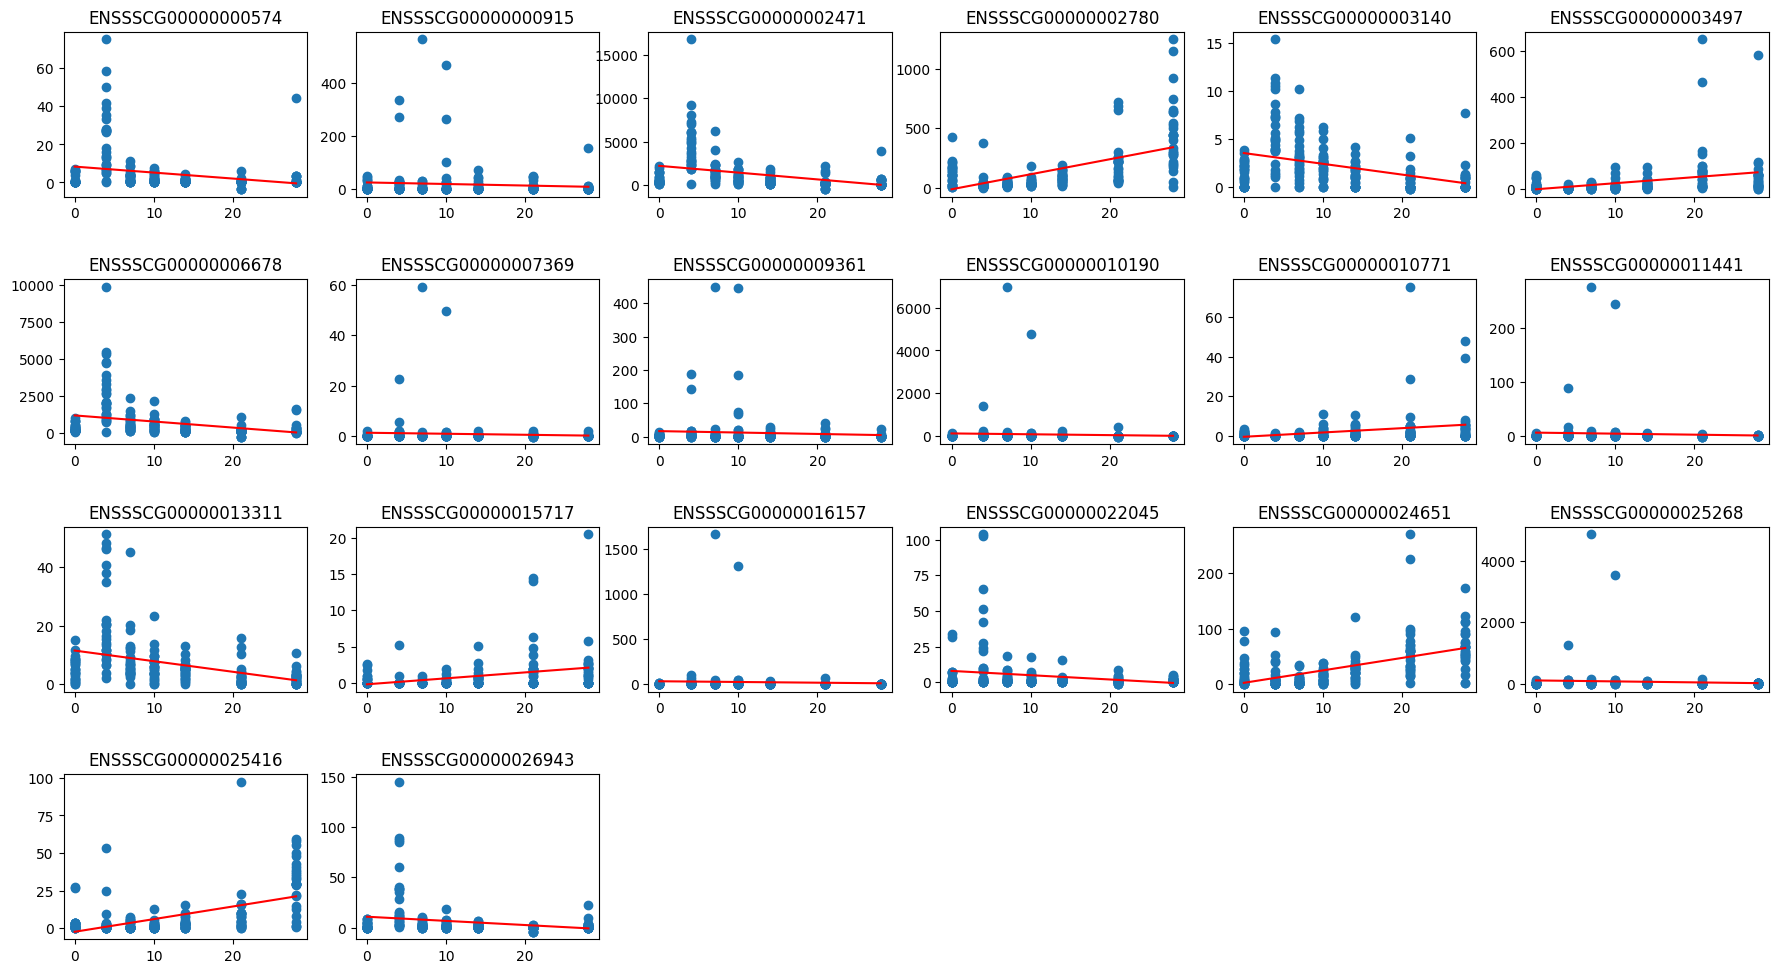

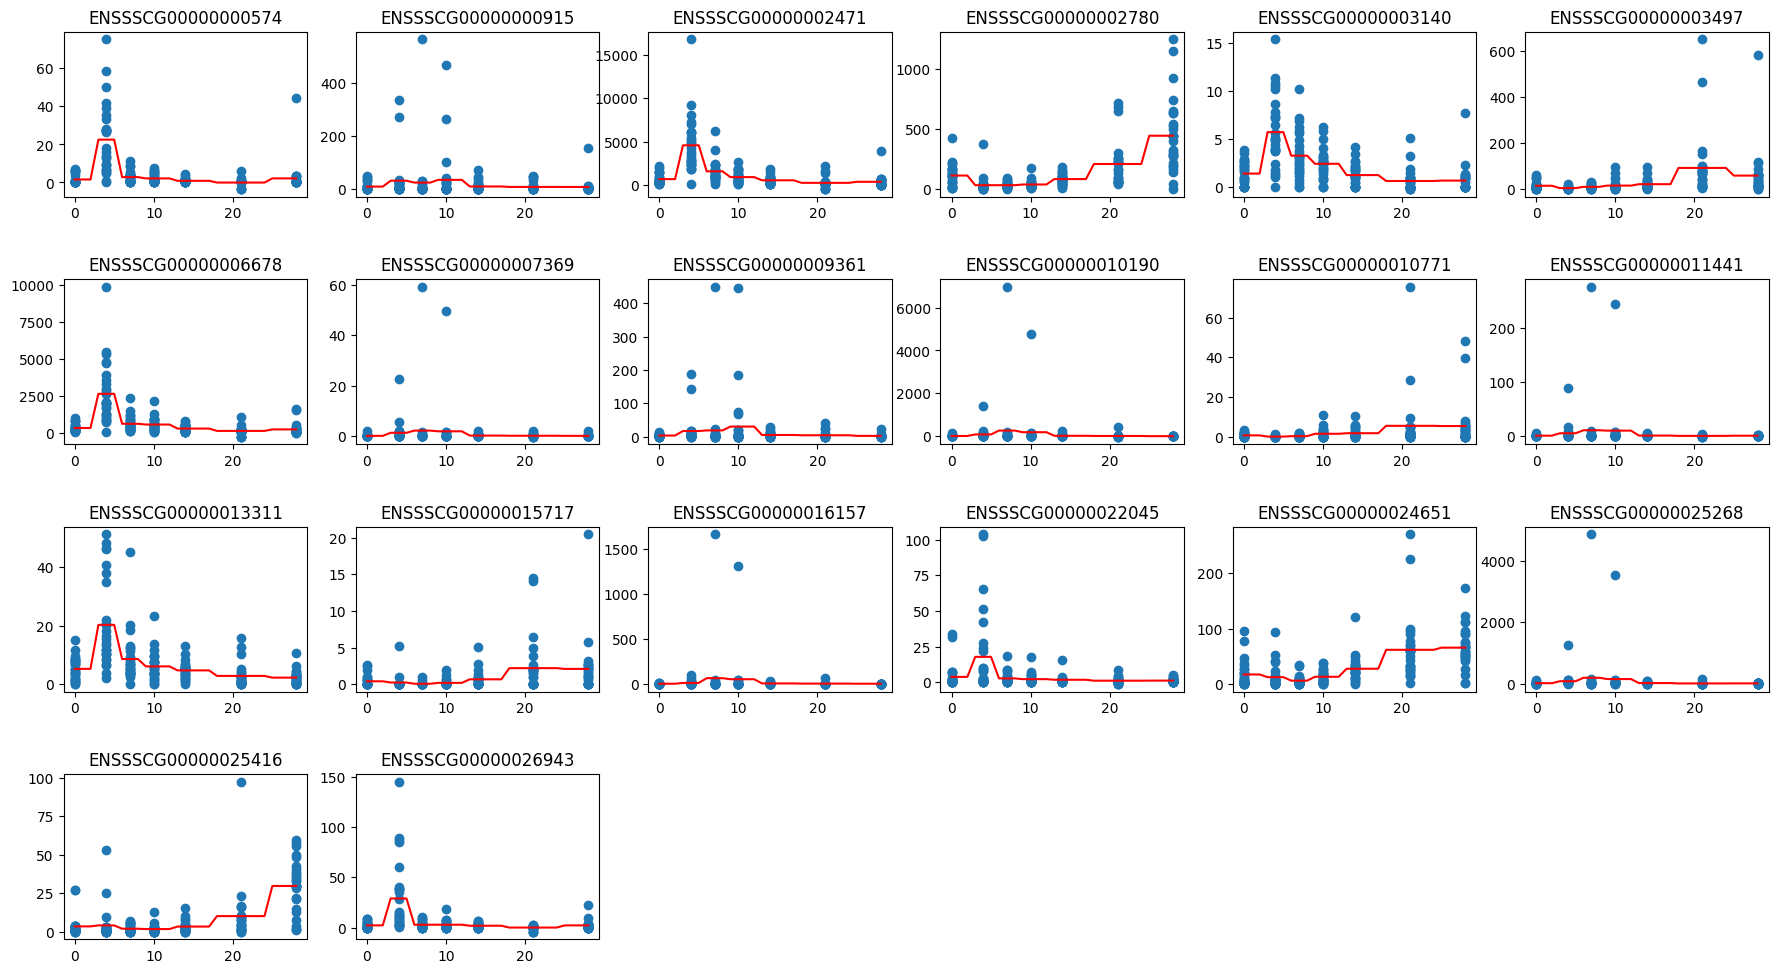

In [16]:
ln_mods_poly = []

def regress_lm(df, gene, n):
    # individual models
    lm = LinearRegression()

    x = df['day'].values.reshape(-1,1)
    y = df[gene].values.reshape(-1,1).ravel()
    lm.fit(x,y)
    
    ln_mods_poly.append(lm)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = lm.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[gene])
    plt.plot(lin, preds, color='red')
    plt.title(gene)
    

plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(gdn_keep.columns):
    
    if gene != 'dpi':

        regress_lm(poly_df2, gene, i)
        
        
        
df_mods_poly = []

def regress_rf(df, gene, n):
    
    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Create the Decision Tree Regressor object
    dt = DecisionTreeRegressor()

    # Create a K-Fold cross-validator with 5 splits
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    # Create the Grid Search object with the parameter grid and K-Fold cross-validator
    grid_search = GridSearchCV(dt, param_grid, cv=kf, n_jobs=3)

    x = df['day'].values.reshape(-1,1)
    y = df[gene].values.reshape(-1,1).ravel()
    
    # Fit the Grid Search object to the data
    grid_search.fit(x, y)

    # Print the best parameters and score
    best_params = grid_search.best_params_
        
    df_func = DecisionTreeRegressor(max_depth = best_params['max_depth'],
                              min_samples_split = best_params['min_samples_split'],
                              min_samples_leaf = best_params['min_samples_leaf'],
                              max_features = best_params['max_features'])
    
    df_mods_poly.append(df_func)
    
    df_func.fit(x,y)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = df_func.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[gene])
    plt.plot(lin, preds, color='red')
    plt.title(gene)
    

plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(gdn_keep.columns):
    
    if gene != 'dpi':

        regress_rf(poly_df2, gene, i)

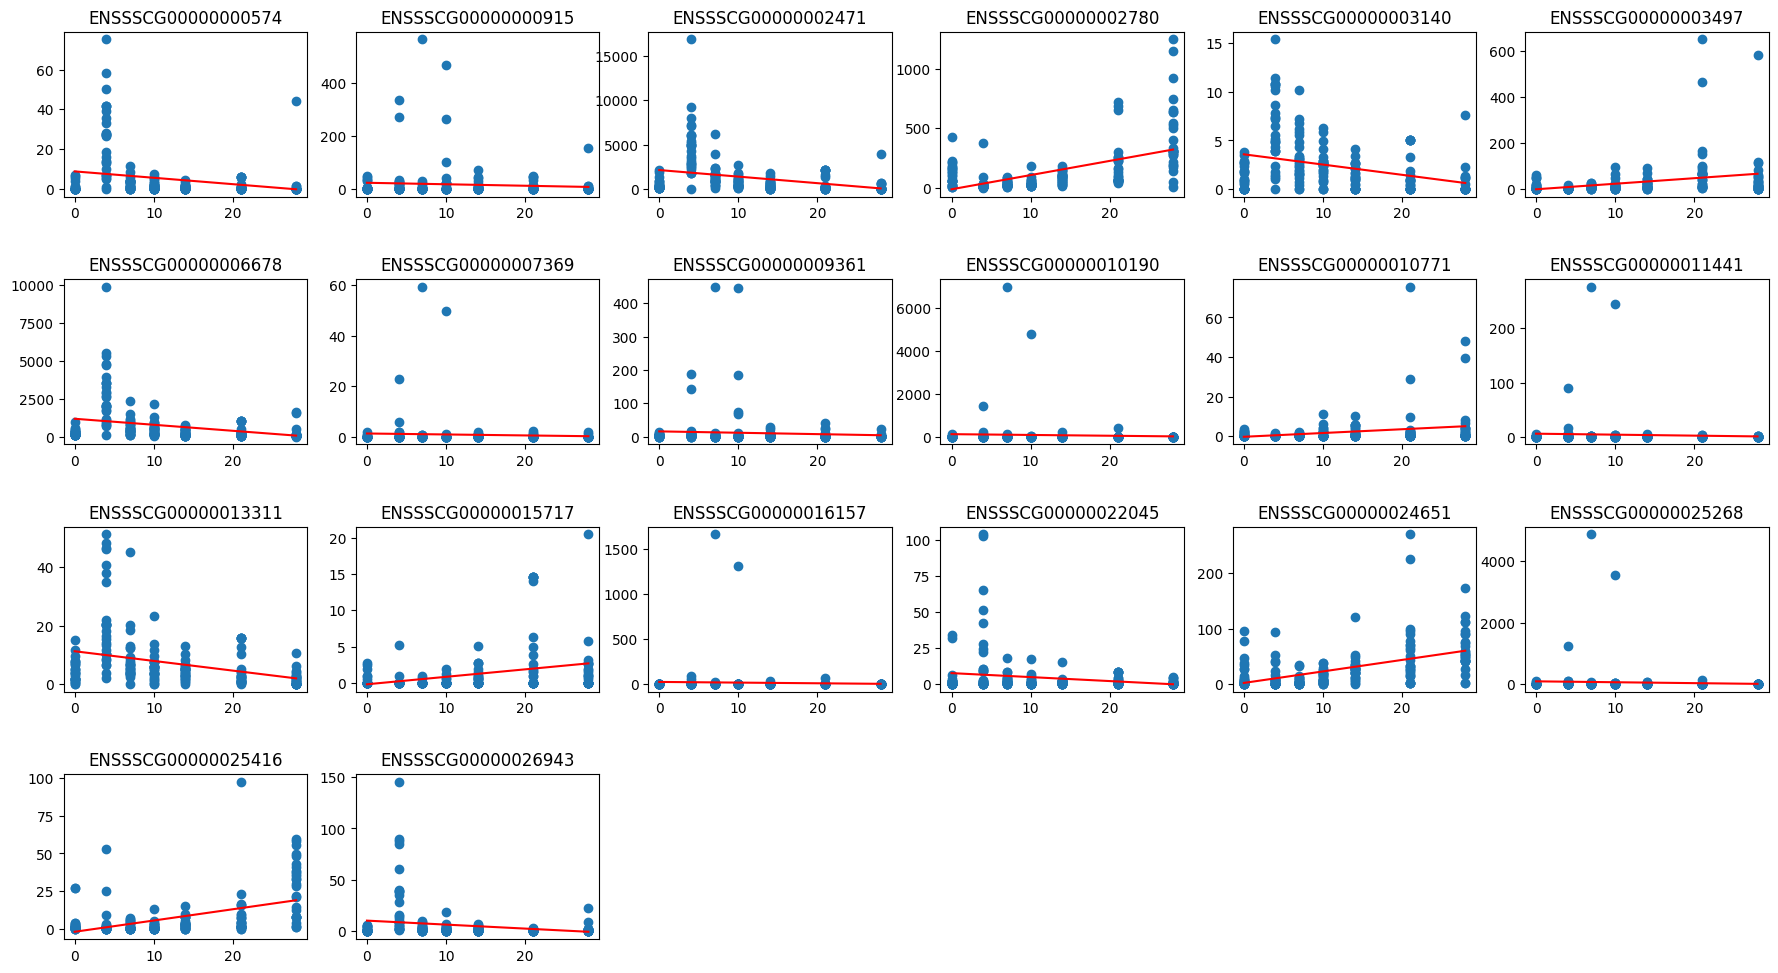

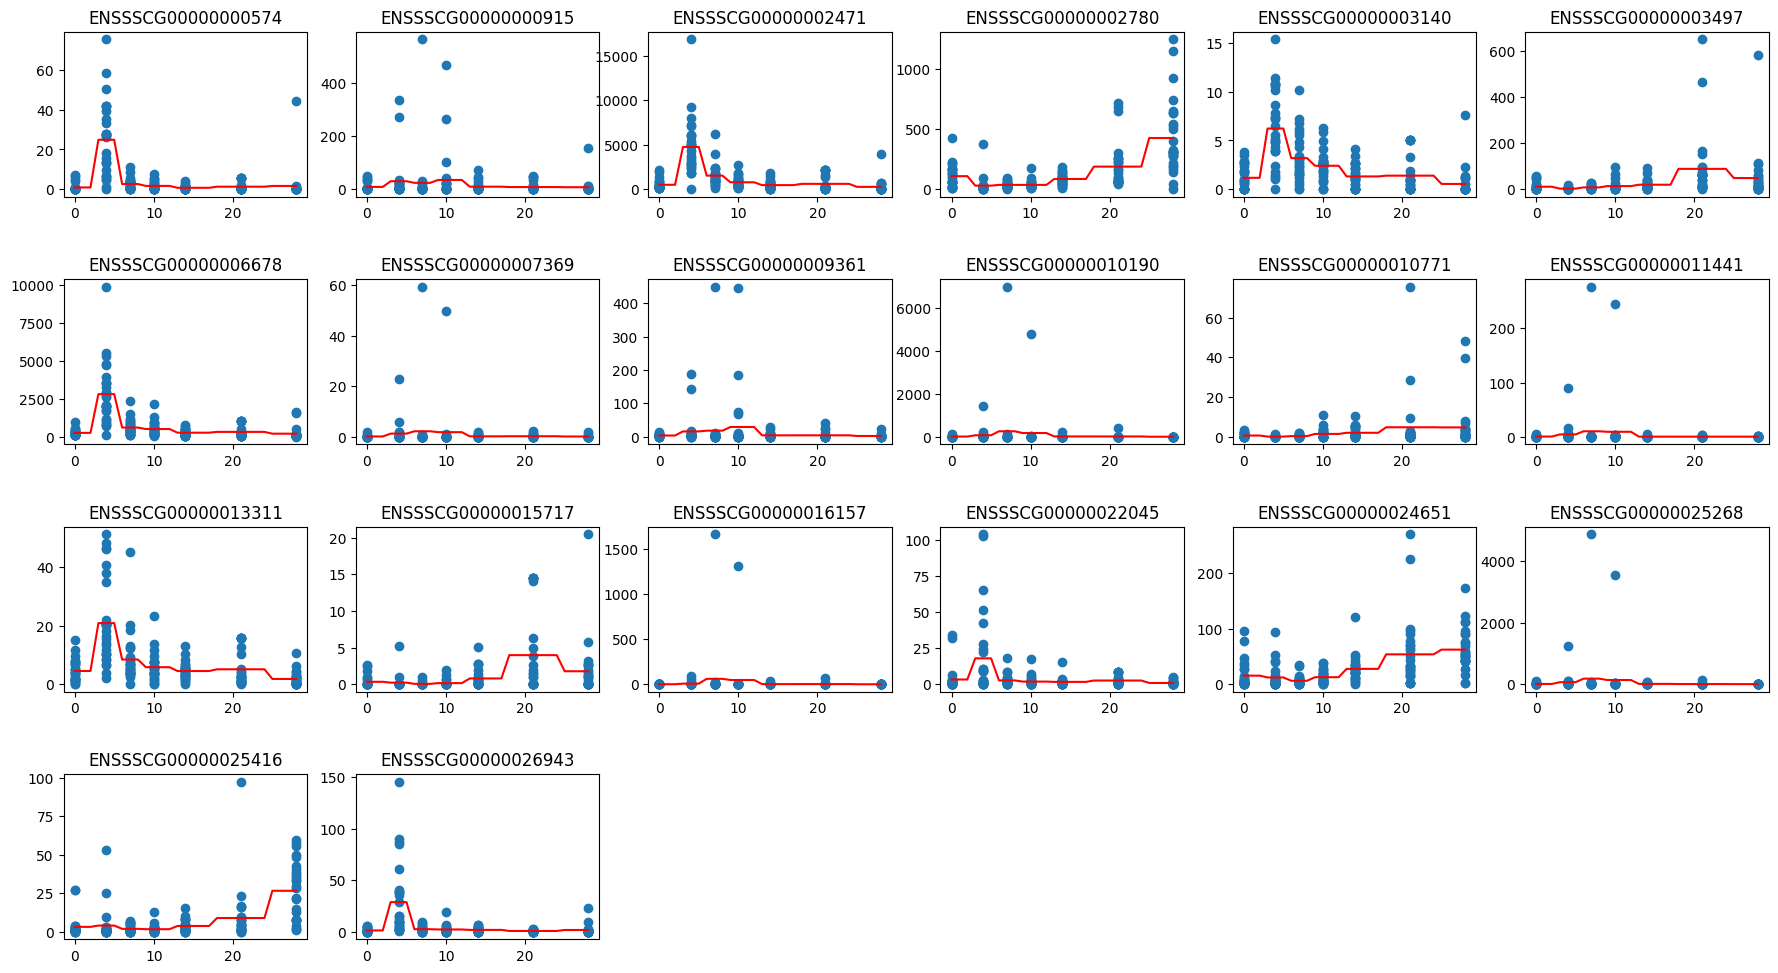

In [17]:
ln_mods_interp = []

def regress_lm(df, gene, n):
    # individual models
    lm = LinearRegression()

    x = df['day'].values.reshape(-1,1)
    y = df[gene].values.reshape(-1,1).ravel()
    lm.fit(x,y)
    
    ln_mods_interp.append(lm)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = lm.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[gene])
    plt.plot(lin, preds, color='red')
    plt.title(gene)
    

plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(gdn_keep.columns):
    
    if gene != 'dpi':

        regress_lm(interp_df2, gene, i)
        
        
        
df_mods_interp = []

def regress_rf(df, gene, n):
    
    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Create the Decision Tree Regressor object
    dt = DecisionTreeRegressor()

    # Create a K-Fold cross-validator with 5 splits
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    # Create the Grid Search object with the parameter grid and K-Fold cross-validator
    grid_search = GridSearchCV(dt, param_grid, cv=kf, n_jobs=3)

    x = df['day'].values.reshape(-1,1)
    y = df[gene].values.reshape(-1,1).ravel()
    
    # Fit the Grid Search object to the data
    grid_search.fit(x, y)

    # Print the best parameters and score
    best_params = grid_search.best_params_
        
    df_func = DecisionTreeRegressor(max_depth = best_params['max_depth'],
                              min_samples_split = best_params['min_samples_split'],
                              min_samples_leaf = best_params['min_samples_leaf'],
                              max_features = best_params['max_features'])
    
    df_mods_interp.append(df_func)
    
    df_func.fit(x,y)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = df_func.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[gene])
    plt.plot(lin, preds, color='red')
    plt.title(gene)
    

plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(gdn_keep.columns):
    
    if gene != 'dpi':

        regress_rf(interp_df2, gene, i)
 

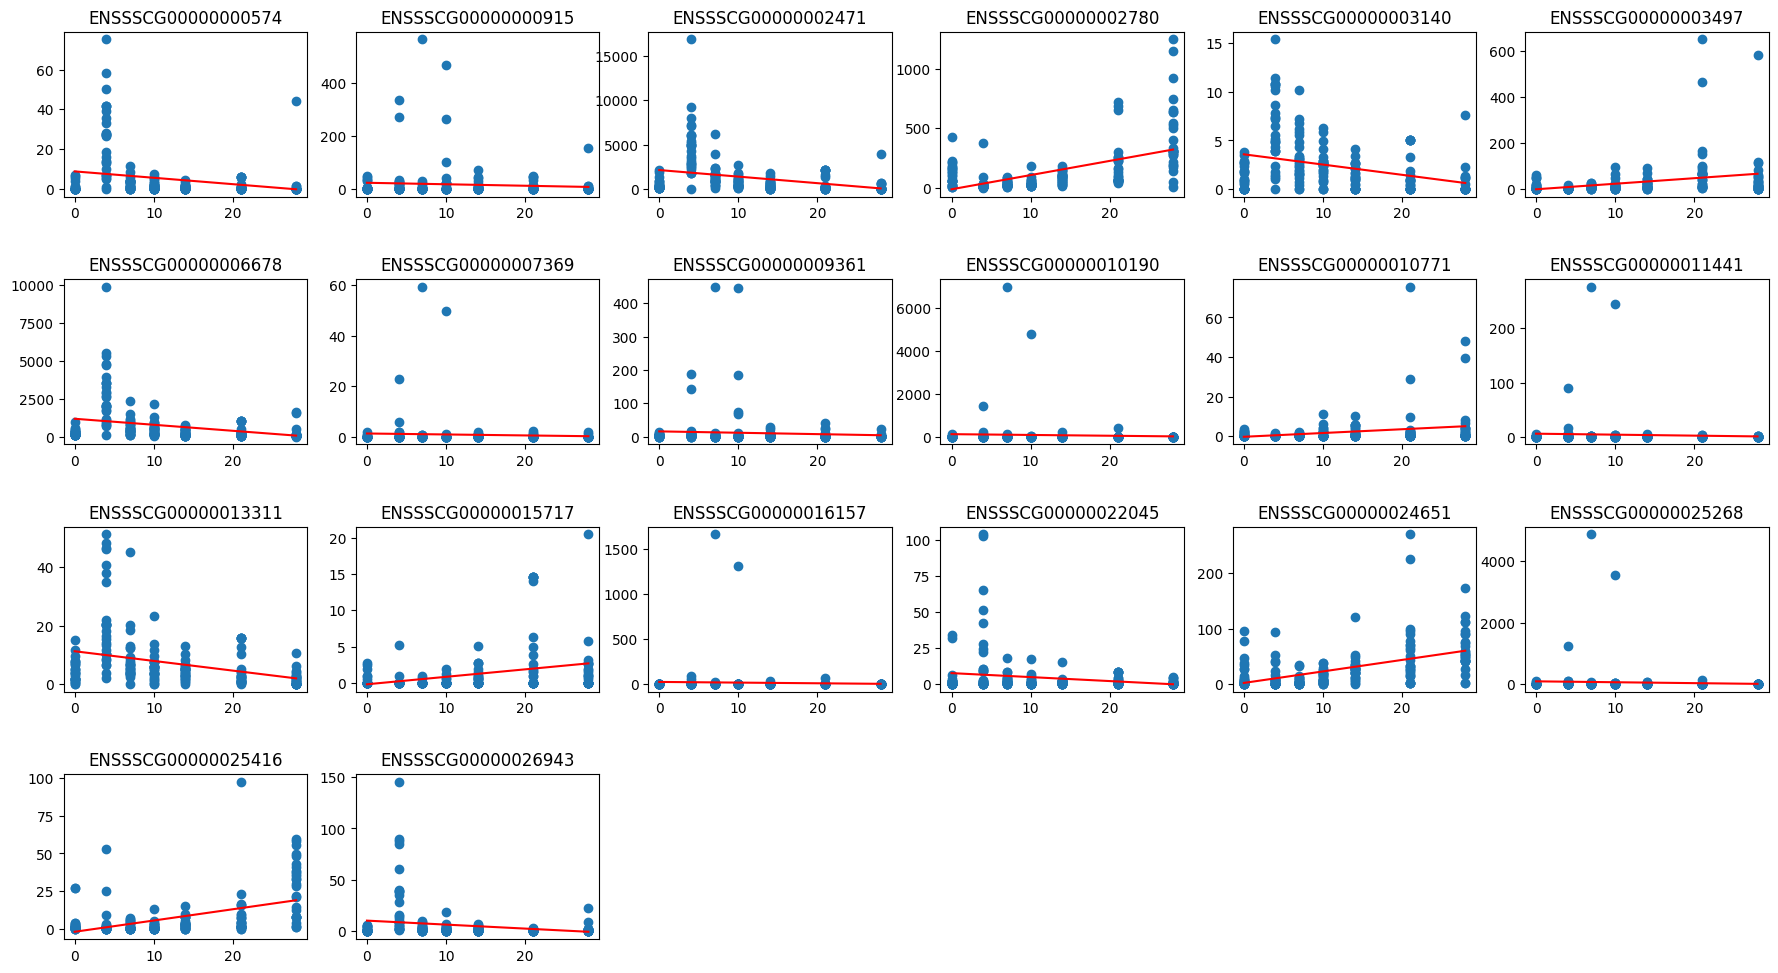

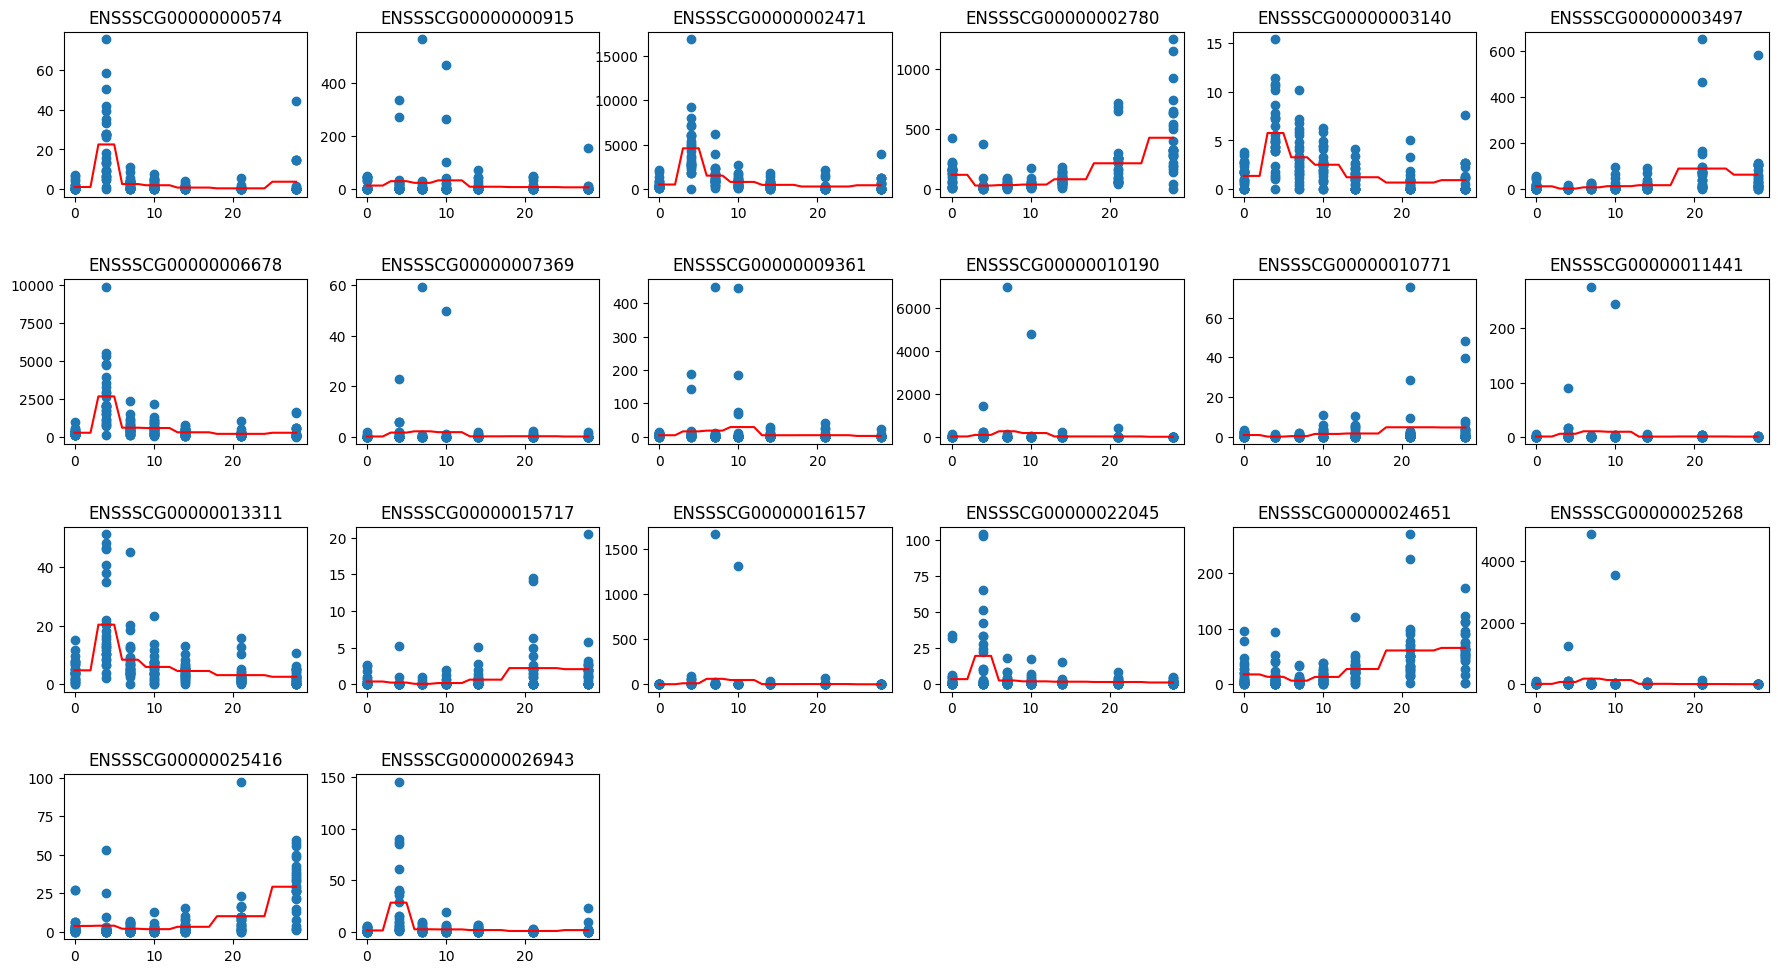

In [18]:
ln_mods_knn = []

def regress_lm(df, gene, n):
    # individual models
    lm = LinearRegression()

    x = df['day'].values.reshape(-1,1)
    y = df[gene].values.reshape(-1,1).ravel()
    lm.fit(x,y)
    
    ln_mods_knn.append(lm)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = lm.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[gene])
    plt.plot(lin, preds, color='red')
    plt.title(gene)
    

plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(gdn_keep.columns):
    
    if gene != 'dpi':

        regress_lm(interp_df2, gene, i)
        
        
        
df_mods_knn = []

def regress_rf(df, gene, n):
    
    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    # Create the Decision Tree Regressor object
    dt = DecisionTreeRegressor()

    # Create a K-Fold cross-validator with 5 splits
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    # Create the Grid Search object with the parameter grid and K-Fold cross-validator
    grid_search = GridSearchCV(dt, param_grid, cv=kf, n_jobs=3)

    x = df['day'].values.reshape(-1,1)
    y = df[gene].values.reshape(-1,1).ravel()
    
    # Fit the Grid Search object to the data
    grid_search.fit(x, y)

    # Print the best parameters and score
    best_params = grid_search.best_params_
        
    df_func = DecisionTreeRegressor(max_depth = best_params['max_depth'],
                              min_samples_split = best_params['min_samples_split'],
                              min_samples_leaf = best_params['min_samples_leaf'],
                              max_features = best_params['max_features'])
    
    df_mods_knn.append(df_func)
    
    df_func.fit(x,y)
    
    lin = np.arange(0,29).reshape(-1, 1) 
    preds = df_func.predict(lin)
    
    ax = plt.subplot(5, 6, n + 1)
    plt.scatter(df['day'], df[gene])
    plt.plot(lin, preds, color='red')
    plt.title(gene)
    

plt.figure(figsize=(22, 15))
plt.subplots_adjust(hspace=0.5)

for i, gene in enumerate(gdn_keep.columns):
    
    if gene != 'dpi':

        regress_rf(knn_df2, gene, i)
 

In [ ]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(poly_df2, test_size=0.2)

# X_train = train.drop('day', axis=1)
# y_train = train['day']
# X_test = train.drop('day', axis=1)
# y_test = train['day']

In [ ]:
# ## Doing a proportional split
# # for example if i have 100 samples and do an 80/20 split
# # of those 80 on the train 

# # percentage of data for training
# train_pct = 0.8

# groups = poly_df2.groupby('gene')

# # randomly sample the data within each group
# def sample_group(group):
#     n_samples = len(group)
#     n_train = int(n_samples * train_pct)
#     train_idx = np.random.choice(group.index, size=n_train, replace=False)
#     test_idx = group.index.difference(train_idx)
#     return {'train': group.loc[train_idx], 'test': group.loc[test_idx]}

# # apply sample_group to each group and combine the results into a dictionary
# group_samples = groups.apply(sample_group).to_dict()

# # combine into single df
# train_data = pd.concat([group_samples[group]['train'] for group in group_samples]).drop('gene', axis=1)
# test_data = pd.concat([group_samples[group]['test'] for group in group_samples]).drop('gene', axis=1)

In [ ]:
# X_train = train_data.drop('ge', axis=1)
# y_train = train_data['ge']
# X_test = test_data.drop('ge', axis=1)
# y_test = test_data['ge']

In [ ]:
# from sklearn.ensemble import VotingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor

# # individual models
# model1 = LinearRegression()
# model2 = DecisionTreeRegressor()
# model3 = RandomForestRegressor()

# ensemble_model = VotingRegressor(estimators=[('lr', model1),
#                                              ('dt', model2),
#                                              ('rf', model3)])

# ensemble_model.fit(X_train, y_train)

# # Evaluate test data
# ensemble_model.score(X_test, y_test)